In [65]:
import duckdb
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import statsmodels.api as sm


In [52]:
DB_PATH = Path().resolve() / "heatgrid.duckdb"

con = duckdb.connect(str(db_path), read_only=True)

In [47]:
con.execute("SHOW TABLES").df()

,name
0,base_combine
1,eia_hourly_raw
2,eia_load_hourly
3,noaa_hourly_avg
4,noaa_hourly_raw
5,noaa_hourly_temp


In [43]:
con.execute("""
    SELECT location, COUNT(*) AS rows
    FROM base_combine
    GROUP BY location
    ORDER BY rows DESC;   
""").df()

,location,rows
0,BOS,58313
1,NYC,58293
2,LAX,58173
3,IAD,58096


In [53]:
# Base table as df 
df = con.execute("SELECT * FROM base_combine").df()

In [126]:
PLOT_DIR = Path("figures")
PLOT_DIR.mkdir(exist_ok=True)

def savefig(name, dpi=300):
    plt.savefig(PLOT_DIR / f"{name}.png", dpi=dpi, bbox_inches="tight")
    plt.close()  

First, we want to look at the relationship between temperature and electricity load for each region.

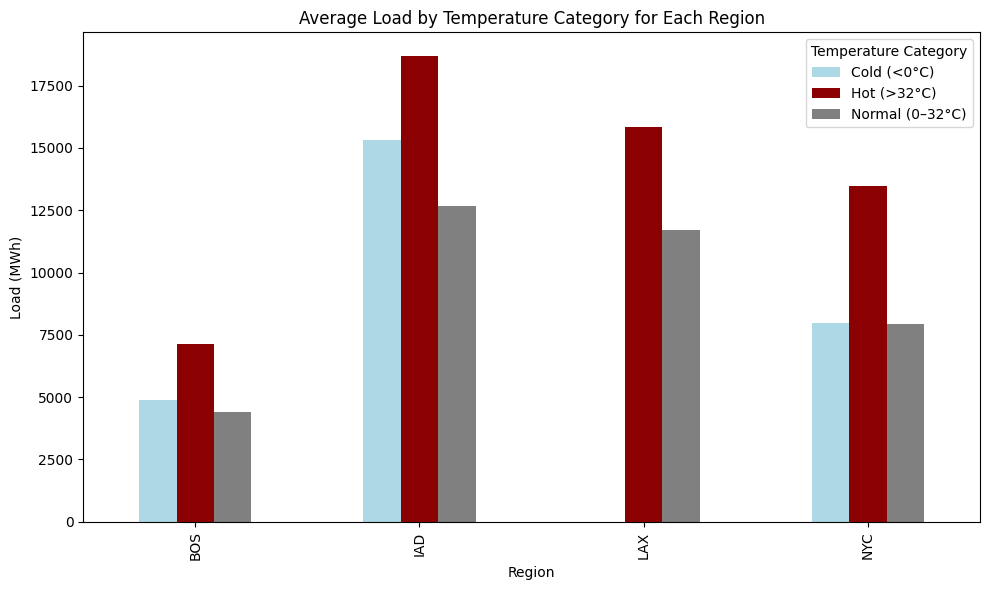

In [128]:
# Temperature categories
def categorize_temp(t):
    if t < 0:
        return "Cold (<0°C)"
    elif t > 32:
        return "Hot (>32°C)"
    else:
        return "Normal (0–32°C)"

df["temp_category"] = df["temp"].apply(categorize_temp)

# Compute mean load 
summary = (
    df.groupby(["location", "temp_category"])["load_mwh"]
      .mean()
      .reset_index()
)

# Plot
pivot = summary.pivot(index="location", columns="temp_category", values="load_mwh")

pivot.plot(kind="bar", figsize=(10,6), color=["lightblue", "darkred", "grey"])

plt.title("Average Load by Temperature Category for Each Region")
plt.ylabel("Load (MWh)")
plt.xlabel("Region")
plt.legend(title="Temperature Category")
plt.tight_layout()
plt.show()
savefig("load_vs_temp_bar_chart")

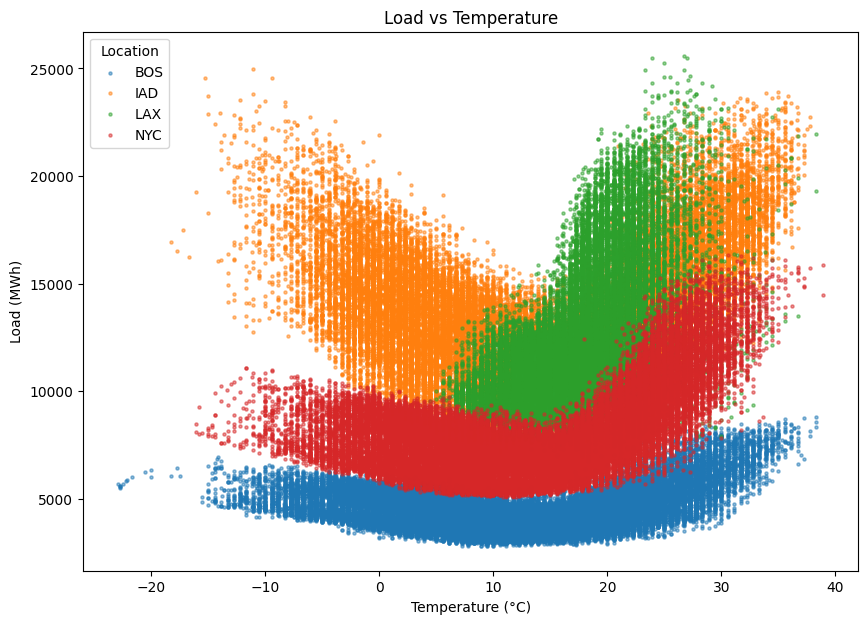

In [129]:
plt.figure(figsize=(10, 7))

for loc in df["location"].unique():
    sub = df[df["location"] == loc]
    plt.scatter(sub["temp"], sub["load_mwh"], s=5, alpha=0.5, label=loc)

plt.xlabel("Temperature (°C)")
plt.ylabel("Load (MWh)")
plt.title("Load vs Temperature")
plt.legend(title="Location")
plt.show()
savefig("load_vs_temp_scatter")

We can model the electricity load as a quadratic function of temperature:
$$
\text{Load} = \beta_0 + \beta_1 T + \beta_2 T^2
$$


`temp` and `temp²` to capture the U-shaped pattern where load increases in very cold (heating) and very hot (cooling) conditions.  `temp²`  shows how strong this curvature is, so we display it to compare each region’s weather sensitivity.


In [108]:
results = {}

for loc in df['location'].unique():
    sub = df[df['location'] == loc].copy()

    # keep only finite rows
    sub = sub[np.isfinite(sub['temp']) & np.isfinite(sub['load_mwh'])]

    # drop any remaining NaNs 
    sub = sub.dropna(subset=['temp', 'load_mwh'])

    # polynomial features
    X = pd.DataFrame({
        'temp': sub['temp'],
        'temp2': sub['temp'] ** 2
    })
    X = sm.add_constant(X)

    y = sub['load_mwh']

    model = sm.OLS(y, X).fit()
    results[loc] = model


In [107]:
for loc, model in results.items():
    print(f"\nRegion: {loc} \n------------")
    print(model.params)


Region: BOS 
------------
const    4492.187395
temp     -103.810334
temp2       5.177428
dtype: float64

Region: IAD 
------------
const    13859.494403
temp      -433.700824
temp2       17.519612
dtype: float64

Region: LAX 
------------
const    8501.105446
temp       24.572269
temp2       9.043017
dtype: float64

Region: NYC 
------------
const    7571.749386
temp     -200.187036
temp2      11.638013
dtype: float64


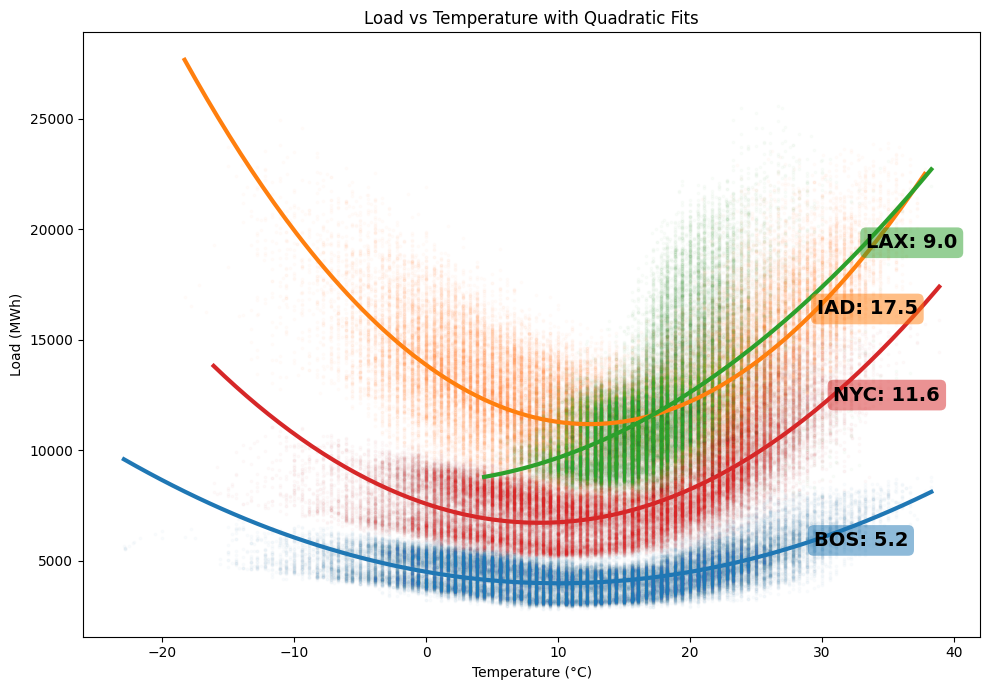

In [130]:
plt.figure(figsize=(10, 7))

# Fix colors 
colors = {"BOS": "tab:blue", "IAD": "tab:orange",
          "LAX": "tab:green", "NYC": "tab:red"}

for loc, color in colors.items():
    sub = df[df["location"] == loc]

    # scatter
    plt.scatter(
        sub["temp"], sub["load_mwh"],
        s=3, alpha=0.02, color=color, label=loc
    )

    # polynomial fit line
    temp_grid = np.linspace(sub["temp"].min(), sub["temp"].max(), 200)
    X_grid = pd.DataFrame({
        "const": 1,
        "temp": temp_grid,
        "temp2": temp_grid**2
    })
    y_pred = results[loc].predict(X_grid)

    plt.plot(temp_grid, y_pred, color=color, linewidth=3)

    # annotate curvature (temp2 coefficient)
    beta2 = results[loc].params["temp2"]
    x_annot = temp_grid[int(0.85 * len(temp_grid))]
    y_annot = y_pred[int(0.85 * len(y_pred))]
    plt.text(
        x_annot, y_annot,
        f"{loc}: {beta2:.1f}",
        fontsize=14,
        fontweight="bold",
        ha="left", va="center",
        color="black",
        bbox=dict(facecolor=color, alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3")
    )
plt.title("Load vs Temperature with Quadratic Fits")
plt.xlabel("Temperature (°C)")
plt.ylabel("Load (MWh)")
plt.tight_layout()
plt.show()
savefig("load_vs_temp_quadratic_fit")


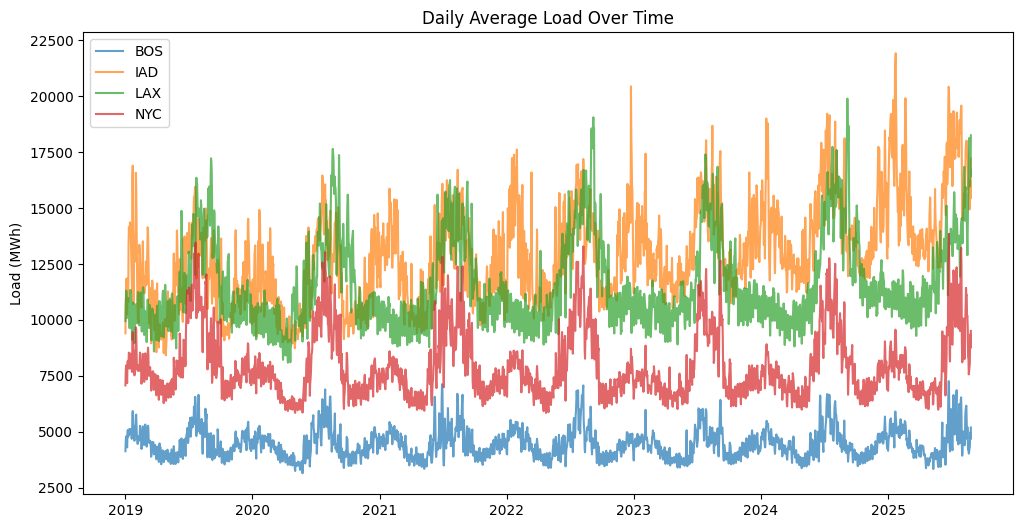

In [131]:
df['date'] = df['hour_utc'].dt.date

daily = (
    df.groupby(['location', 'date'])['load_mwh']
      .mean()
      .reset_index()
)

# plot one line per region
plt.figure(figsize=(12,6))
for loc in daily['location'].unique():
    sub = daily[daily['location'] == loc]
    plt.plot(sub['date'], sub['load_mwh'], label=loc, alpha=0.7)

plt.title("Daily Average Load Over Time")
plt.ylabel("Load (MWh)")
plt.legend()
plt.show()
savefig("daily_avg_load_over_time")


In [39]:
con.close()
